In [1]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from script.plotDisplay import plotDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
mlp_model = ctypes.CDLL("modele/mlp/target/release/libmlp_classification.so")

# Définir les types d'arguments et de retour des fonctions C
PROGRESS_CALLBACK = ctypes.CFUNCTYPE(None, ctypes.c_int, ctypes.c_double)
mlp_model.mlpInit.argtypes = [ctypes.POINTER(ctypes.c_size_t), ctypes.c_size_t, ctypes.c_double]
mlp_model.mlpInit.restype = ctypes.c_void_p

mlp_model.mlpTrain.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_bool,
    PROGRESS_CALLBACK,
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.c_char_p  
]
mlp_model.mlpTrain.restype = None


mlp_model.mlpPredict.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.POINTER(ctypes.c_double)
]
mlp_model.mlpPredict.restype = None

mlp_model.mlpFree.argtypes = [ctypes.c_void_p]
mlp_model.mlpFree.restype = None


# First test case

In [3]:
parameter = np.array([2, 1], dtype=np.uintp)
learning_rate = 0.1
epochs = 1000000
checkpoint_interval = 1000
callback_interval = 1000
checkpoint_enable = False
log_enable = False
log_tag = "simpleTestCase".encode('utf-8')

# tensorboard_dir = "./log/"
parameter_ptr = parameter.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, parameter.size, learning_rate)

X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0]
], dtype=np.float64)

y_train = np.array([
    [1.0],
    [-1.0],
    [1.0]
], dtype=np.float64)

print(f'vecteur {X_train}')
print(f'vecteur {X_train.shape}')

layer : 1
neural matrix : [NeuralMatrix { matrix: [[-0.630057681680074, -0.9521692410494538]], bias: [0.0], input_size: 2, output_size: 1 }]
vecteur [[0. 0.]
 [0. 1.]
 [1. 0.]]
vecteur (3, 2)


In [4]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,  # Nombre total d'époques
    1,
    True,  # is_classification
    callback_func,  # Fonction de callback
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [0. 0.] , predictions = [0.99996571]
Sample [0. 1.] , predictions = [-0.99997626]
Sample [1. 0.] , predictions = [0.9999987]
ndim = 1


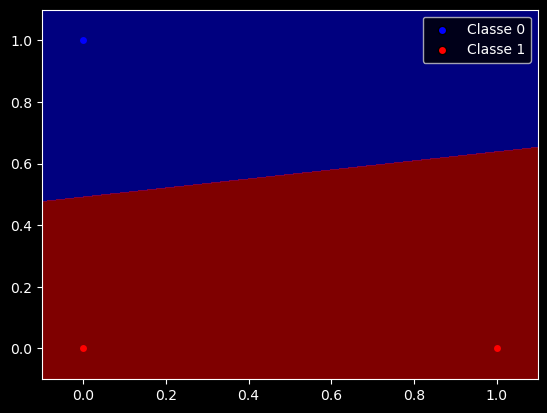

In [5]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)


plotDisplay(X_train, y_train, nn, mlp_model)


mlp_model.mlpFree(nn)

# Xor test case

In [59]:
neurons_size = np.array([2, 3, 1], dtype=np.uintp)
learning_rate = 0.01
epochs = 1000000
callback_interval = 10000
checkpoint_enable = False
log_enable = False
log_tag = "xorTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
], dtype=np.float64)

y_train = np.array([
    [-1.0],
    [1.0],
    [1.0],
    [-1.0]
], dtype=np.float64)

print(f'vecteur {X_train}')
print(f'vecteur {y_train}')

layer : 2
neural matrix : [NeuralMatrix { matrix: [[0.0757034467807105, 0.8123154921658258], [-0.24743835547648807, 0.5869741242674205], [0.9562188251987931, -0.24840918576829152]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }, NeuralMatrix { matrix: [[0.4426615482189842, 0.6090849003395595, 0.6390274707669157]], bias: [0.0], input_size: 3, output_size: 1 }]
vecteur [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
vecteur [[-1.]
 [ 1.]
 [ 1.]
 [-1.]]


In [60]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs,
    1,
    True, 
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [0. 0.] , predictions = [-0.98349316]
Sample [0. 1.] , predictions = [0.9354716]
Sample [1. 0.] , predictions = [0.93564529]
Sample [1. 1.] , predictions = [-0.89017087]
ndim = 1


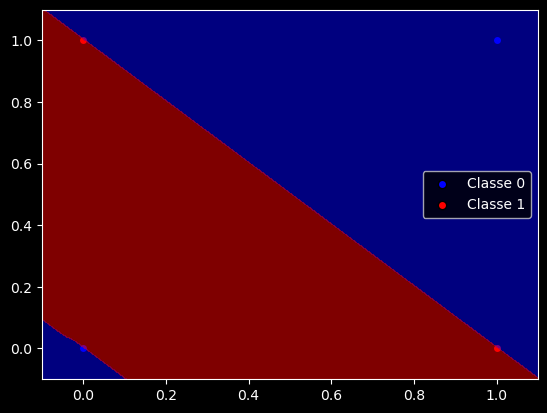

In [61]:
predictions = []
for k in range(len(X_train)):
    prediction = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        prediction.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    predictions.append(prediction.tolist())
    print("Sample", X_train[k], ", predictions =", prediction)


plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

# Multi class test

In [65]:
neurons_size = np.array([2, 3], dtype=np.uintp)
learning_rate = 0.01
epochs = 1000000
callback_interval = 1000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "simpleMultiTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [1.0, 1.0],  # Classe A
    [5.0, 5.0],  # Classe B
    [0, 3.0] 
], dtype=np.float64)

y_train = np.array([
    [1.0, 0.0, 0.0],  # Classe A
    [0.0, 1.0, 0.0],  # Classe B
    [0.0, 0.0, 1.0]   # Classe C
], dtype=np.float64)

print(f"shape : {X_train.shape}")
print(f"shape : {y_train.shape}")

shape : (3, 2)
shape : (3, 3)
layer : 1
neural matrix : [NeuralMatrix { matrix: [[0.6037348751338993, -0.3576773672528648], [-0.8253110985284771, 0.3729368665223336], [-0.5193843467834744, 0.013762668465941985]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }]


In [66]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    3,
    epochs,
    16,
    True,  
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [1. 1.] , predictions = [0.98473764 0.00954454 0.00571782]
Sample [5. 5.] , predictions = [5.73452167e-03 9.94259074e-01 6.40391556e-06]
Sample [0. 3.] , predictions = [0.00488545 0.00173989 0.99337466]
ndim = multi


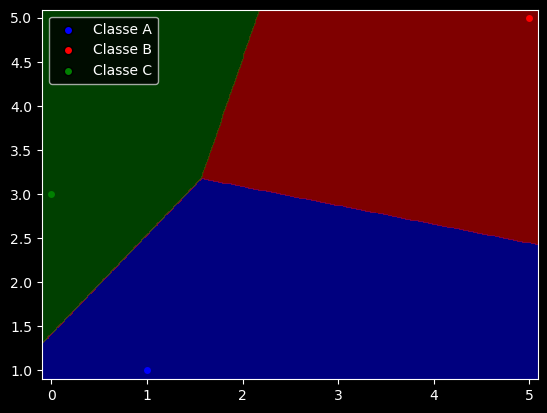

In [67]:
for k in range(len(X_train)):
    predictions = np.zeros(3, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)

plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

# Multi class 

In [141]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1.0, 0.0, 0.0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
                [0.0, 1.0, 0.0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
                [0.0, 0.0, 1.0] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
                [0, 0, 0] for p in X], dtype=np.float64)

X_train = X[[not np.all(arr == [0, 0, 0]) for arr in Y]]
y_train = Y[[not np.all(arr == [0, 0, 0]) for arr in Y]]

neurons_size = np.array([2, y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.1
epochs = 100000
callback_interval = 1000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "MultiTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)


# print(f"{X_train}")
print(f"shape : {X_train.shape}")
print(f"shape : {y_train.shape}")

shape : (391, 2)layer : 1
neural matrix : [NeuralMatrix { matrix: [[-0.5286748051311219, 0.9155961337437377], [-0.6293345696144503, 0.35274685485458424], [-0.9594681656511375, -0.6829528138333383]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }]

shape : (391, 3)


In [142]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

trainResult = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs, 
    1,
    True,
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

ndim = multi


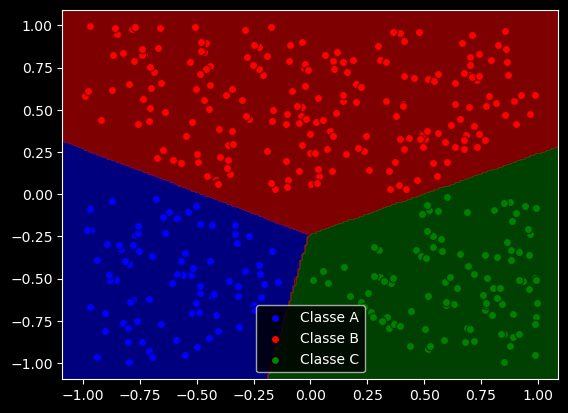

In [143]:
# for k in range(len(X_train)):
#     predictions = np.zeros(3, dtype=np.float64)
#     mlp_model.mlpPredict(
#         nn,
#         X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
#         X_train[k].size,
#         True,
#         predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
#     )
    # print("Sample", X_train[k], ", predictions =", predictions)

plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

## Cross entropy

In [126]:

X_train = np.random.random((500, 2)) * 2.0 - 1.0
y_train = np.array([[1.0] if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else [-1.0] for p in X_train], dtype=np.float64)

# X_train = np.random.random((500, 2)) * 2.0 - 1.0
# y_train = np.array([[1.0] if p[0] * p[0] + p[1] * p[1] <= 0.5 else [-1.0] for p in X_train], dtype=np.float64)

print(f"X_train : {X_train[:10]}")
print(f"X_train : {y_train[:10]}")

neurons_size = np.array([X_train.shape[1], 4, y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.1
epochs = 100000
batch_size = 1
classification = True
callback_interval = 1000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "CrossEntropy".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)


# print(f"{X_train}")
print(f"shape : {X_train.shape}")
print(f"shape : {y_train.shape}")

X_train : [[-0.31380713 -0.79049504]
 [-0.34879336  0.01311316]
 [ 0.24194079 -0.00892761]
 [-0.78555985 -0.08407055]
 [-0.56854216 -0.78654084]
 [ 0.08570067  0.79927094]
 [-0.19178762  0.87870837]
 [ 0.65069137 -0.60064266]
 [ 0.23745683  0.02251357]
 [-0.48406085 -0.34447016]]
X_train : [[-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]]
layer : 2
neural matrix : [NeuralMatrix { matrix: [[-0.4362301056932405, 0.6660944478099968], [-0.5894240619476334, 0.5271531465344075], [-0.13267749843695853, -0.3384573358498715], [0.971533729086699, 0.4795328722325469]], bias: [0.0, 0.0, 0.0, 0.0], input_size: 2, output_size: 4 }, NeuralMatrix { matrix: [[-0.24850478821768895, -0.4295461239429055, 0.924148084375612, -0.7302359202216073]], bias: [0.0], input_size: 4, output_size: 1 }]
shape : (500, 2)
shape : (500, 1)


In [127]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs, 
    batch_size,
    classification,
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Accuracy : 1.0
ndim = 1


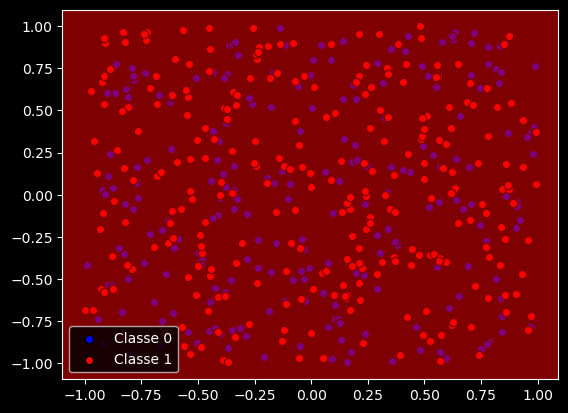

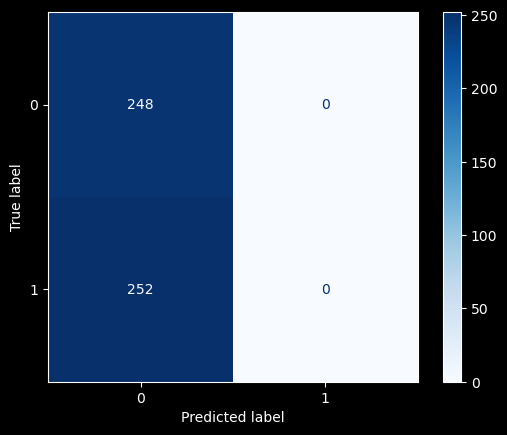

In [128]:

accurate = 0
for k in range(len(X_train)):
    predictions = np.zeros(3, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    if np.argmax(predictions) == np.argmax(y_train[k]):
        accurate += 1
    # print("Sample", X_train[k], ", predictions =", predictions)

print(f"Accuracy : {accurate / len(X_train)}")
plotDisplay(X_train, y_train, nn, mlp_model)

cm = confusion_matrix(np.argmax(X_train, axis=1), np.argmax(y_train, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


mlp_model.mlpFree(nn)

# Cross multi class

In [129]:

X_train = np.random.random((1000, 2)) * 2.0 - 1.0
y_train = np.array([
    [1.0, 0.0, 0.0] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else 
    [0.0, 1.0, 0.0] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else 
    [0.0, 0.0, 1.0] 
    for p in X_train
])


neurons_size = np.array([X_train.shape[1], 4, y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.1
epochs = 100000
batch_size = 1
classification = True
callback_interval = 1000
checkpoint_enable = False
log_enable = False
log_tag = "crossLinearTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

# print(y_train[:10])
# print(X_train[:10])
# print(f"shape {X_train.shape}")
# print(f"shape {y_train.shape}")

# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='rbw')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.ylabel('X3')
# plt.title('Training Data Visualization')
# plt.show()


layer : 2
neural matrix : [NeuralMatrix { matrix: [[0.7105039288317974, 0.6813185294783901], [0.8983397221155447, -0.7045392042962484], [0.1955453152117368, 0.7625993262783326], [0.33014078012988923, 0.32388842985406363]], bias: [0.0, 0.0, 0.0, 0.0], input_size: 2, output_size: 4 }, NeuralMatrix { matrix: [[-0.4355264556216314, 0.9014028392856979, 0.8123045147803585, 0.14010783536987903], [0.38989435938242867, 0.47220539141861373, -0.11261200998498166, -0.32699931703326657], [0.619845789738096, 0.19073645496276903, 0.2287839973624335, -0.4065927636460751]], bias: [0.0, 0.0, 0.0], input_size: 4, output_size: 3 }]


In [130]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs, 
    batch_size,
    True,
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

ndim = multi


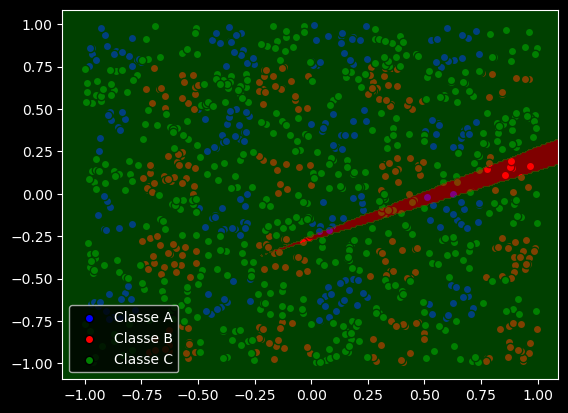

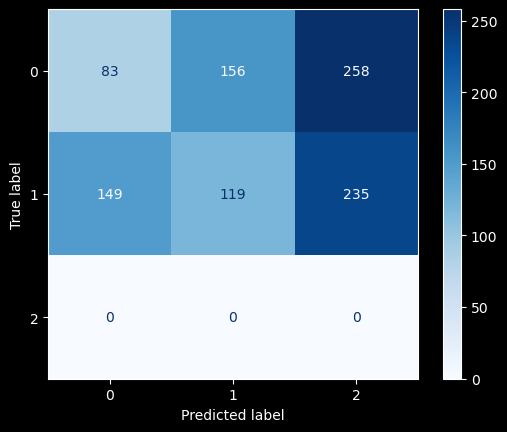

In [131]:
# for k in range(len(X_train)):
#     predictions = np.zeros(3, dtype=np.float64)
#     mlp_model.mlpPredict(
#         nn,
#         X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
#         X_train[k].size,
#         True,
#         predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
#     )
    # print("Sample", X_train[k], ", predictions =", predictions)

plotDisplay(X_train, y_train, nn, mlp_model)

cm = confusion_matrix(np.argmax(X_train, axis=1), np.argmax(y_train, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

mlp_model.mlpFree(nn)

# Simple linear test

In [21]:
neurons_size = np.array([1, 1], dtype=np.uintp)
learning_rate = 0.001
epochs = 1000000
callback_interval = 1000
checkpoint_enable = False
callback_interval = 1000
log_enable = False
log_tag = "simpleLinearTestCase".encode('utf-8')
parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [3.0],
    [7.0],
], dtype=np.float64)

y_train = np.array([
    [-3.0],
    [2.0],
], dtype=np.float64)

layer : 1
neural matrix : [NeuralMatrix { matrix: [[0.4563547132340626]], bias: [0.0], input_size: 1, output_size: 1 }]


In [22]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,
    1,
    False,
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [23]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        False,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)

# plotDisplay(X_train, y_train, nn, mlp_model)
mlp_model.mlpFree(nn)

Sample [3.] , predictions = [-3.]
Sample [7.] , predictions = [2.]


# Linear test

In [24]:
neurons_size = np.array([1, 3, 1], dtype=np.uintp)
learning_rate = 0.01
epochs = 10000000
callback_interval = 10000
checkpoint_enable = False
callback_interval = 1000
log_enable = False
log_tag = "linearTestCase".encode('utf-8')
parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [3.0],
    [7.0],
    [9.0],
], dtype=np.float64)

y_train = np.array([
    [8.0],
    [2.0],
    [6.0],
], dtype=np.float64)

layer : 2
neural matrix : [NeuralMatrix { matrix: [[-0.16539181750603626], [0.6679491906264179], [0.01407493608664323]], bias: [0.0, 0.0, 0.0], input_size: 1, output_size: 3 }, NeuralMatrix { matrix: [[0.6303039213066199, -0.909550264753368, -0.5565915854098282]], bias: [0.0], input_size: 3, output_size: 1 }]


In [25]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,
    16,
    False,
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/10000000 [00:00<?, ?it/s]

In [26]:
allPrediction = []
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        False,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    allPrediction.append(predictions)
    print("Sample", X_train[k], ", predictions =", predictions)

# plotDisplay(X_train, y_train, nn, mlp_model)
mlp_model.mlpFree(nn)

Sample [3.] , predictions = [5.33333333]
Sample [7.] , predictions = [5.33333333]
Sample [9.] , predictions = [5.33333333]


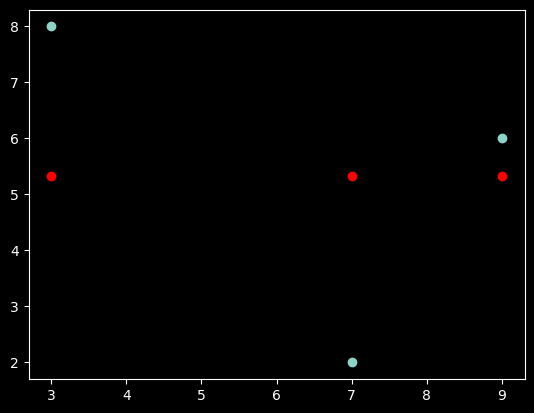

In [27]:
plt.scatter(X_train, y_train)
plt.scatter(X_train, allPrediction, c='red')
plt.show()